In [1]:
import numpy as np
import pandas as pd

import itertools
from operator import itemgetter

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Функции и классы

In [3]:
# разбиение выборки на тренировочную и валидационную
def train_test_split(x, y, test_size=0.3):
    indexes = range(x.shape[0])
    train_len = int(x.shape[0]*(1-test_size))

    train_indexes = np.random.choice(indexes, size=train_len, replace=False)
    test_indexes = [i for i in indexes if i not in train_indexes]

    return x[train_indexes], y[train_indexes], x[test_indexes], y[test_indexes]

In [4]:
# вычисляет ROC
def roc(y, probas):
    # combined (real value, score)
    data = sorted(np.array([(y[i], probas[i]) for i in range(len(y))]), reverse=True, key=lambda e: e[1])
    
    tt = float(len(y[y == 1]))
    tf = float(len(y) - tt)
    ft, ff = 0.0, 0.0
    
    tprs, fprs  = [0.0], [0.0]
    
    for d in data:
        if d[0] == 1:
            ft += 1
        else:
            ff += 1
            
        tprs.append(ft / tt)
        fprs.append(ff / tf)
        
    return fprs, tprs

In [5]:
# вычисляем ROC_AUC
def roc_auc(y, y_proba):
    fprs, tprs = roc(y, y_proba)
    
    return np.trapz(tprs, x = fprs, dx=0.1)

In [6]:
# стандартизация
def normalize(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - means[j])/stds[j]
            
    return X

In [7]:
# нормализация
def minimax(X):
    minis = np.min(X, axis=0)
    maxis = np.std(X, axis=0)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i][j] = (X[i][j] - minis[j])/(maxis[j] - minis[j])
            
    return X

In [8]:
class LogisticClassifier:
    def fit(self, X, y, iterations, alpha=10e-4, reg=None, lambda_=1e-8):
        self.x = X.T
        #print(self.x)
        self.y = y
        self.alpha = alpha
        self.n = self.x.shape[1]
        self.losses = [] # на добрую память
        
        self.reg = reg
        self.l = lambda_
        
        W = np.random.randn(self.x.shape[0])
        
        for i in range(1, iterations+1):
            loss, grad = self.__calc_loss_grad(W)
            W -= self.alpha*grad
            
            self.losses.append(loss)
        
        self.W = W
    
    def proba(self, x):
        return np.dot(self.W, x.T)
    
    def predict(self, x, treshold=0.5):
        probs = self.proba(x)
        return [1.0 if z >= treshold else 0 for z in self.__sigmoid(probs)]
    
    def __sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def __calc_loss_grad(self, w):
        pred = self.__sigmoid(np.dot(w, self.x))
                
        err = np.zeros(self.y.shape)
        s = (pred != 0) * (pred != 1)
        
        err[s] = self.y[s] * np.log(pred[s]) + (1.0 - self.y[s]) * np.log(1.0 - pred[s])
        ferr = -np.mean(err)
        
        #print('New:', ferr)
        #print('Old:', -np.mean(self.y * np.log(pred) + (1.0 - self.y) * np.log(1.0 - pred)))
        
        loss = np.sum(err)
        
        r = 0
        if self.reg == 'l1':
            r = self.l * np.sign(w)
        elif self.reg == 'l2':
            r = self.l * w
        
        grad = 1/self.n * np.dot((pred - self.y), self.x.T) + r
        
        return loss, grad
        

In [9]:
# кросс-валидация
def cv(x_train, y_train, x_test, y_test, model, params, score_func):
    keys = params.keys()
    vals = params.values()
    
    perms = list(itertools.product(*vals))
    settings = [dict(zip(keys, p)) for p in perms]
    print('Total: ', len(settings))
    
    scores = []
    for s in settings:
        print('Processing: ', s)
        model.fit(x_train, y_train, **s)
        proba = model.proba(x_test)
        
        score = score_func(y_test, proba)
        print('Score: ', score)
        scores.append((s, score))
        
    print('Done')
    return max(scores, key=itemgetter(1))[0]

### Загрузка и анализ данных

In [10]:
train_df = pd.read_csv('classification_train.csv')

In [11]:
train_df.shape

(10000, 13)

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
choose                 10000 non-null int64
dtypes: float64(11), int64(2)
memory usage: 1015.8 KB


In [13]:
train_df.describe()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,4999.50000,45.800900,1.974800,1702.440000,1.724300,0.37060,0.121500,0.117200,0.059100,0.02770,0.018000,64.435200,0.110900
std,2886.89568,8.030274,1.766883,523.789062,0.798845,0.48299,0.326724,0.321675,0.235824,0.16412,0.132958,13.595024,0.314024
min,0.00000,23.000000,0.000000,200.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,33.000000,0.000000
25%,2499.75000,40.000000,0.000000,1300.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,55.000000,0.000000
50%,4999.50000,46.000000,2.000000,1550.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,63.000000,0.000000
75%,7499.25000,51.000000,3.000000,2150.000000,2.000000,1.00000,0.000000,0.000000,0.000000,0.00000,0.000000,74.000000,0.000000
max,9999.00000,68.000000,9.000000,3950.000000,4.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,100.000000,1.000000


In [14]:
train_df.head()

,Id,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
0,0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


physics                0.195183
mean_exam_points       0.109409
chemistry              0.091878
biology                0.071310
qualification          0.042160
years_of_experience    0.029010
english                0.022227
age                    0.017165
Id                     0.012043
geography              0.006366
history               -0.004700
lesson_price          -0.134013
Name: choose, dtype: float64

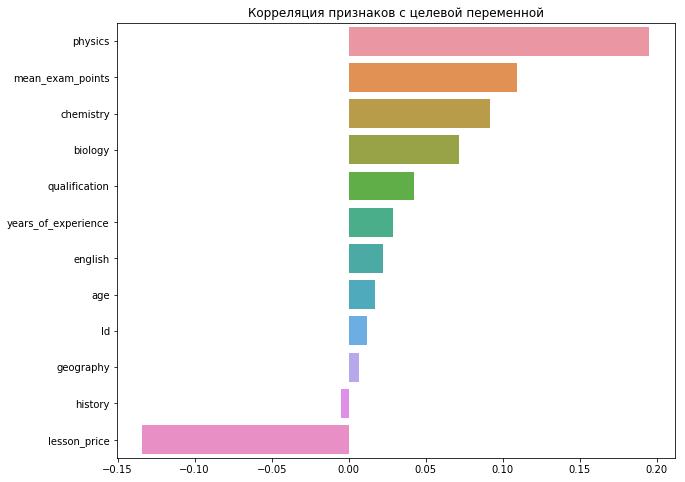

In [15]:
target_corr = train_df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr.values, y=target_corr.index)

plt.title('Корреляция признаков с целевой переменной')
target_corr

### Подготовка данных

In [16]:
train_target = train_df['choose']
train_data = train_df.drop(['Id', 'choose'], axis=1)

In [17]:
nx_train, ny_train, nx_test, ny_test = train_test_split(normalize(train_data.values), train_target.values, test_size=0.3)

In [18]:
mx_train, my_train, mx_test, my_test = train_test_split(minimax(train_data.values), train_target.values, test_size=0.3)

### Подбор парметров

In [19]:
m = LogisticClassifier()

In [20]:
# m.fit(mx_train, my_train, iterations=1000)

In [21]:
p = {'iterations': [100, 500, 1000, 2000, 3000,5000,8000,10000], 'alpha': [0.01, 0.05, 0.1, 0.5, 0.9], 'reg': [None, 'l1', 'l2'], 'lambda_': [10e-4, 10e-2, 10e-8]}

In [22]:
%%time
# пока отключим, здесь было много прогонов с целью найти лучшие данные
# cv(nx_train, ny_train, nx_test, ny_test, m, p, roc_auc)

Total:  360
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 0.001}
Score:  0.704055392617114
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 0.1}
Score:  0.6499049794633034
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 1e-07}
Score:  0.36212342667608804
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.523437861301206
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.5855555878205935
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.4860469843482301
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.41822587462451555
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.4859641707508828
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.567135477667754
Processing:  {'iterations': 100, 'alpha':

Score:  0.8464313254800232
Processing:  {'iterations': 500, 'alpha': 0.5, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.825561223447218
Processing:  {'iterations': 500, 'alpha': 0.5, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8465689896418473
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 0.001}
Score:  0.8465689896418473
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 0.1}
Score:  0.8465689896418473
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 1e-07}
Score:  0.8465689896418473
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.847332595539466
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.5958481349194826
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.8465689896418473
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.8464291744774947
Processing:  {'iterations': 500, 'al

Score:  0.847332595539466
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.6472312833203735
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.8465668386393188
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.8464302499787589
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.825561223447218
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8465732916469044
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 0.001}
Score:  0.8465689896418473
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 0.1}
Score:  0.8465689896418473
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 1e-07}
Score:  0.8465689896418473
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.847332595539466
Processing:  {'iterations': 

Score:  0.8465743671481687
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': None, 'lambda_': 0.1}
Score:  0.8465743671481687
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': None, 'lambda_': 1e-07}
Score:  0.8465732916469044
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.847332595539466
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.48211495172612573
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.8465743671481687
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.8464291744774947
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.825561223447218
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8465732916469044
Processing:  {'iterations': 5000, 'alpha': 0.1, 'reg': None, 'lambda_': 0.001}
Score:  0.8465689896418473
Processing:  {'ite

Score:  0.8464291744774947
Processing:  {'iterations': 8000, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.825561223447218
Processing:  {'iterations': 8000, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8465689896418473
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 0.001}
Score:  0.846810977426304
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 0.1}
Score:  0.8466281422113813
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 1e-07}
Score:  0.846016181992022
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.84743476815957
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.6396317913871707
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.846097920088105
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.8465560836266763
Processing:  {'it

{'iterations': 500, 'alpha': 0.1, 'reg': 'l1', 'lambda_': 1e-07}

In [23]:
%%time
# пока отключим, здесь было много прогонов с целью найти лучшие данные
# cv(mx_train, my_train, mx_test, my_test, m, p, roc_auc)

Total:  360
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 0.001}
Score:  0.3775901822516695
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 0.1}
Score:  0.4376207506063222
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': None, 'lambda_': 1e-07}
Score:  0.46643771542032736
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.37675185695903424
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.38333389387773403
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.3489164676734044
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.44924270451462456
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.6026325656366351
Processing:  {'iterations': 100, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.4592241318101473
Processing:  {'iterations': 100, 'al

Score:  0.8140798788227571
Processing:  {'iterations': 500, 'alpha': 0.5, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.47803226493570555
Processing:  {'iterations': 500, 'alpha': 0.5, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8139179437736597
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 0.001}
Score:  0.8270683154145974
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 0.1}
Score:  0.8302721380782794
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': None, 'lambda_': 1e-07}
Score:  0.8476926123984947
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.8319687191311312
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.5773158891915828
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.8450157014714914
Processing:  {'iterations': 500, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.8265812646130811
Processing:  {'iterations': 500, 

Score:  0.7982712810681734
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.5976947922933864
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.7913740936308453
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.7663688307417498
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.47803226493570555
Processing:  {'iterations': 2000, 'alpha': 0.1, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.7990884302390037
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 0.001}
Score:  0.8572156389396492
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 0.1}
Score:  0.8555663927473027
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': None, 'lambda_': 1e-07}
Score:  0.8575968091321402
Processing:  {'iterations': 2000, 'alpha': 0.5, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.8543356863741621
Processing:  {'iteration

Score:  0.8137659739583527
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': None, 'lambda_': 0.1}
Score:  0.8103541270392917
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': None, 'lambda_': 1e-07}
Score:  0.799524409217343
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.8176461868655728
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.6067893137815447
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.806328172587884
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.811531270280808
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.47803226493570555
Processing:  {'iterations': 5000, 'alpha': 0.05, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.792396775748607
Processing:  {'iterations': 5000, 'alpha': 0.1, 'reg': None, 'lambda_': 0.001}
Score:  0.831389489917052
Processing:  {'iterat

Score:  0.8466898607483142
Processing:  {'iterations': 8000, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 0.1}
Score:  0.47803226493570555
Processing:  {'iterations': 8000, 'alpha': 0.9, 'reg': 'l2', 'lambda_': 1e-07}
Score:  0.8618743857367608
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 0.001}
Score:  0.7546459788413173
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 0.1}
Score:  0.7248785798545325
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': None, 'lambda_': 1e-07}
Score:  0.6886811137643546
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.001}
Score:  0.6981505771738846
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 0.1}
Score:  0.5902731844278274
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l1', 'lambda_': 1e-07}
Score:  0.7373164372794414
Processing:  {'iterations': 10000, 'alpha': 0.01, 'reg': 'l2', 'lambda_': 0.001}
Score:  0.6857264219454379
Processing

{'iterations': 5000, 'alpha': 0.9, 'reg': None, 'lambda_': 0.001}

### Обучение финальной модели

In [24]:
m.fit(nx_train, ny_train, 500, alpha=0.1, reg='l1', lambda_=1e-07)
n_proba = m.proba(nx_test)

In [25]:
roc_auc(ny_test, n_proba)

0.8489845654813566

### Загрузка тестовых данных и сохранение предсказаний

In [30]:
test_df = pd.read_csv('classification_test.csv')

In [31]:
test_df.shape

(10000, 12)

In [32]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Id                     10000 non-null int64
age                    10000 non-null float64
years_of_experience    10000 non-null float64
lesson_price           10000 non-null float64
qualification          10000 non-null float64
physics                10000 non-null float64
chemistry              10000 non-null float64
biology                10000 non-null float64
english                10000 non-null float64
geography              10000 non-null float64
history                10000 non-null float64
mean_exam_points       10000 non-null float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


In [33]:
test_df = test_df.drop(['Id'], axis=1)

In [34]:
test_df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points
0,32.0,2.0,2700.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0
1,35.0,6.0,1800.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,71.0
2,44.0,2.0,1200.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0
3,44.0,4.0,2950.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,92.0
4,38.0,3.0,1400.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,58.0


In [35]:
test_Xn = normalize(test_df.values)

In [37]:
predictions = m.predict(test_Xn)

In [38]:
#prs = np.array(predictions)

In [40]:
#len(prs[prs == 0])

4063

In [41]:
res = pd.DataFrame(data=np.array(predictions).astype('float64'), columns=['choose'])
res.index += 10000
res.to_csv('MLevanov_class_pred(logreg-norm).csv', index_label='Id')